In [26]:
import json
import pandas as pd
from processing import tokenization_tagging, stopwords_removal, simple_headline_cleaning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [5]:
# Only relevant parts of the training dataset is the text and the rating so we will extract that

review_dict = {
    'reviewText' : [],
    'rating' : []
}

with open("amazonBooks_small_10000_sentiments.json", 'r') as review_json:
    for review in review_json:
        review_dict['reviewText'].append(json.loads(review)['reviewText'])
        review_dict['rating'].append(json.loads(review)['overall'])

sentiments = pd.DataFrame(review_dict)

In [6]:
sentiments.head()

,reviewText,rating
0,"I bought both boxed sets, books 1-5. Really a...",5.0
1,I enjoyed this short book. But it was way way ...,3.0
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4.0
3,I really enjoyed this adventure and look forwa...,4.0
4,It was a decent read.. typical story line. Not...,3.0


In [9]:
# Clean amazon reviewText
sentiments['reviewText'] = sentiments['reviewText'].apply(simple_headline_cleaning)
sentiments['reviewText_lemmatized'] = sentiments['reviewText'].apply(tokenization_tagging)
sentiments['reviewText_cleaned'] = sentiments['reviewText_lemmatized'].apply(stopwords_removal)
sentiments.sample(5)

,reviewText,rating,reviewText_lemmatized,reviewText_cleaned
5185,the first part of the book was a little slower...,4.0,the first part of the book be a little slower ...,first part book little slower read last partbu...
8518,this is a great compliment to scott hahns earl...,5.0,this be a great compliment to scott hahn earli...,great compliment scott hahn earlier work 34lam...
8939,i read a lot of books frequently they promise ...,4.0,i read a lot of book frequently they promise b...,read lot book frequently promise never deliver...
8785,if you8217ve landed on this page you probably ...,3.0,if you8217ve land on this page you probably al...,you8217ve land page probably already know tony...
3433,when i picked kat vespucci takes taiwan i had ...,5.0,when i pick kat vespucci take taiwan i have no...,pick kat vespucci take taiwan idea prequel sec...


In [10]:
# Data for training classifier 
X = sentiments[['reviewText_cleaned']]
y = sentiments['rating']
print("Shape of X: ", X.shape, "Shape of y: ", y.shape)

Shape of X:  (10000, 1) Shape of y:  (10000,)


In [24]:
#Train-Test Split for sentiment data
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
print ('x_train',x_train.shape, 'x_test',x_test.shape, 'y_train',y_train.shape, 'y_test',y_test.shape)

x_train (8000, 1) x_test (2000, 1) y_train (8000,) y_test (2000,)


In [20]:
# Training the model
vectorizer = CountVectorizer()
matrix_train = vectorizer.fit_transform(x_train['reviewText_cleaned'])

classifier = MultinomialNB()
classifier.fit(matrix_train,y_train)

MultinomialNB()

/Users/tohdekai/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[[   1    0    0    8   41]
 [   0    2    0   24   49]
 [   0    0   25   53  123]
 [   0    0    0  155  340]
 [   0    0    0   28 1151]]


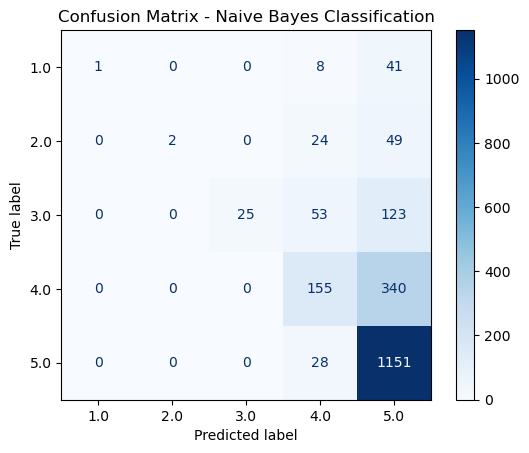

In [27]:
# Evaluating the model
matrix_test = vectorizer.transform(x_test['reviewText_cleaned'])
predicted_results = classifier.predict(matrix_test)

disp = plot_confusion_matrix(classifier, matrix_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=None, values_format = '')
disp.ax_.set_title('Confusion Matrix - Naive Bayes Classification')


print(disp.confusion_matrix)

plt.show()

In [29]:
cm = confusion_matrix(matrix_test, predicted_results)

TN, FP, FN, TP = cm.ravel(matrix_test)

total = TP + FP + FN + TN
precision = TP / (TP + FP) 
recall = TP / (TP + FN)
accuracy = (TP + TN) / total
print (f'Precision is {precision:.4f}, recall is {recall:.4f}, accuracy is {accuracy:.4f}')

TypeError: len() of unsized object